In [8]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'indoor-outdoor:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4374946%2F7511544%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240211%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240211T124018Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D107546f7fad26b4da9217ed3a728c879578f06a24f3bbdadbc26d9a72e91efcf8f90631871b317f251ada196c99b3d0ad0b0509d32faf9abb2566a10eab8223d5f201db36d03d5d4c6e18313279b133a096c43bf0395924801f571c350644e2432ac3ea2a65a0dbece20302b03b58db29bf3288fbd759ae74d8562bf9cb0eaf699526e455c854895dd4cfb2ae04ed7b1eeca150d89fd61c0dae51250579e2184f43d846c7c7d0261b27b484ee222021ca5e78df6e4a2f6dda395f77196fae8fc971fe9887f2f74bf636175f65562551d416de53f63abfe951483be1a646bd271cf53ccc0f820df5305644fd41c53cdbe2f4e6987c9908463edd4e26c56195653'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 13893796019 bytes downloaded
Downloaded and uncompressed: indoor-outdoor
Data source import complete.


In [9]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from tqdm import tqdm
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm


import warnings
warnings.filterwarnings('ignore')

In [10]:
import torch
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

In [11]:
import os

In [12]:
class DatasetSplitter:

    def __init__(self, d_ratios: dict[str, float]):
        assert sum(d_ratios.values()) == 1.0
        self.d_ratios = d_ratios

    def split(self, old_path, new_path):
        ratios_names = list(self.d_ratios.keys())
        ratios = list(self.d_ratios.values())
        ratios_name2index = {ratios_name:i for i, ratios_name in enumerate(ratios_names)}

        classes = list(filter(
                        lambda path: os.path.isdir(os.path.join(old_path, path)),
                        os.listdir(old_path))
        )
        classes_data = {
            class_dir: os.listdir(os.path.join(old_path, class_dir))
                for class_dir in classes
        }
        for class_name, data in classes_data.items():
            np.random.shuffle(data)
        classes_count = {class_dir: len(classes_data[class_dir])
                            for class_dir in classes}
        cum_ratios = np.cumsum([0] + ratios)
        classes_borders = {class_dir: (cum_ratios * classes_count[class_dir]).astype(int)
                            for class_dir in classes}

        if not os.path.exists(new_path):
            os.mkdir(new_path)

        for ratios_name in ratios_names:
            ratio_path = os.path.join(new_path, ratios_name)
            if not os.path.exists(ratio_path):
                os.mkdir(ratio_path)

            for class_name in classes:
                class_path = os.path.join(new_path, ratios_name, class_name)
                if not os.path.exists(class_path):
                    os.mkdir(class_path)

        for class_name in classes:
            for ratios_name in ratios_names:
                files_path = os.path.join(new_path, ratios_name, class_name)
                border_index = ratios_name2index[ratios_name]
                start, end = classes_borders[class_name][border_index:border_index + 2]
                for file_idx in range(start, end):
                    file_name = classes_data[class_name][file_idx]
                    os.symlink(os.path.join(old_path, class_name, file_name),
                              os.path.join(new_path, ratios_name, class_name, file_name)
                              )

In [13]:
splitter = DatasetSplitter({"train": 0.8 * 0.7,
                 "val": 0.8 * 0.3,
                 "test": 0.2
                })

In [14]:
splitter.split("/kaggle/input/indoor-outdoor", "/kaggle/working/in-out_dataset")

In [15]:
dataset_path = "/kaggle/working/in-out_dataset"

In [16]:
from PIL import Image


class InoutDataset(torch.utils.data.Dataset):
    def __init__(self, path, transform, target_transform):
        self.path = path
        self.transform = transform
        self.target_transform = target_transform

        self.classes = os.listdir(path)
        self.class2indexes = {}
        self.files = []
        self.count = 0

        for class_name in self.classes:
            files = os.listdir(os.path.join(self.path, class_name))
            cur = len(files)

            self.class2indexes[class_name] = (self.count, self.count + cur)
            self.files += files
            self.count += cur

    def get_class(self, index):
        for class_name, ranges in self.class2indexes.items():
            start, end = ranges
            if start <= index < end:
                return class_name
        return None

    def __len__(self):
        return self.count

    def __getitem__(self, index):
        class_name = self.get_class(index)
        path = os.path.join(self.path, class_name, self.files[index])
        im = self.transform(Image.open(path))
        target = self.target_transform(class_name)
        return im, target

In [57]:
target_transform = lambda x: int(x == 'indoor')

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


train_data = InoutDataset(os.path.join(dataset_path, "train"), transform=transform, target_transform=target_transform)
val_data = InoutDataset(os.path.join(dataset_path, "val"), transform=transform, target_transform=target_transform)
test_data = InoutDataset(os.path.join(dataset_path, "test"), transform=transform, target_transform=target_transform)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False)

outdoor


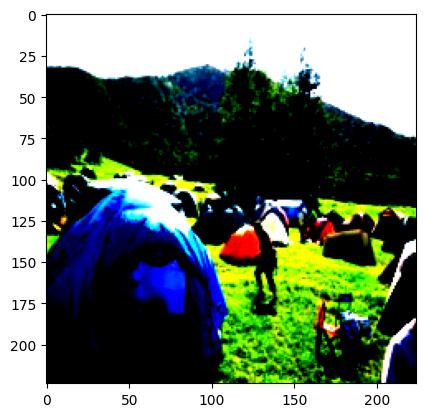

outdoor


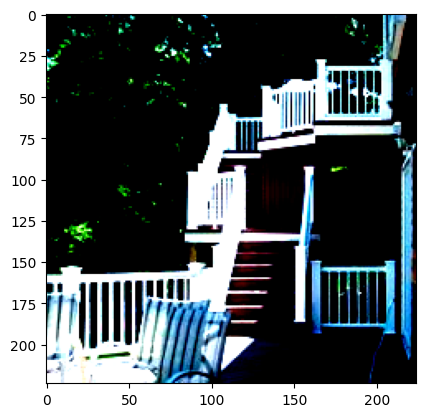

In [18]:
import matplotlib.pyplot as plt

print(train_data.get_class(0))
plt.imshow(train_data[1][0].permute(1, 2, 0))
plt.show()

print(train_data.get_class(200000))
plt.imshow(train_data[200001][0].permute(1, 2, 0))
plt.show()

In [42]:
def train(data, model, optimizer, n_epochs=20, steps_per_epoch=500, device='cuda'):
    train_dataloader = data['train']
    val_dataloader = data['val']
    model = model.to(device)
    accuracies, losses = {'train': [], 'val': []}, {'train': [], 'val': []}
    for epoch in range(n_epochs):
        train_loss = []
        train_accuracy = []
        for step, (x_train, y_train) in tqdm(enumerate(train_dataloader)):
            if step >= steps_per_epoch:
                break
            x_train = x_train.to(device)
            y_train = y_train.to(device)
            y_pred = model(x_train)
            loss = F.cross_entropy(y_pred, y_train)
            train_loss.append(loss.detach().cpu().numpy())
            train_accuracy.extend((torch.argmax(y_pred, dim=-1) == y_train).detach().cpu().numpy().tolist())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        val_loss = []
        val_accuracy = []
        with torch.no_grad():
            for step, (x_val, y_val) in tqdm(enumerate(val_dataloader)):
                if step >= steps_per_epoch:
                    break
                x_val = x_val.to(device)
                y_val = y_val.to(device)
                y_pred = model(x_val).to(device)
                loss = F.cross_entropy(y_pred, y_val)
                val_loss.append(loss.cpu().numpy())
                val_accuracy.extend((torch.argmax(y_pred, dim=-1) == y_val).cpu().numpy().tolist())

        train_loss = np.mean(train_loss)
        val_loss = np.mean(val_loss)
        train_acc = np.mean(train_accuracy)
        val_acc = np.mean(val_accuracy)

        accuracies['train'].append(train_acc)
        accuracies['val'].append(val_acc)
        losses['train'].append(train_loss)
        losses['val'].append(val_loss)

        print(f'Epoch: {epoch}, loss: {train_loss=}, {val_loss=}'
              f' accuracy: {train_acc=}, {val_acc=}')
    return accuracies, losses

In [43]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, roc_auc_score, f1_score, accuracy_score
def evaluate(test_loader, model, device='cuda'):

    y_true = []
    y_preds_proba = []
    model.to(device)
    with torch.no_grad():
        for step, (x_test, y_test) in enumerate(tqdm(test_loader)):
            x_test = x_test.to(device)
            y_test = y_test.to(device)
            y_pred = model(x_test).to(device)
            y_preds_proba.append(y_pred[:, 1].cpu())
            y_true.append(y_test.cpu())

    y_true = torch.hstack(y_true)
    y_preds_proba = torch.hstack(y_preds_proba)
    y_preds = (y_preds_proba >= 0.5).type(torch.LongTensor)

    cm = confusion_matrix(y_true, y_preds)
    print(f"F1 = {f1_score(y_true=y_true, y_pred=y_preds)},"
          f"Acc = {accuracy_score(y_true=y_true, y_pred=y_preds)},"
          f"ROC-AUC = {roc_auc_score(y_true=y_true, y_score=y_preds_proba)}")
    cm_display = ConfusionMatrixDisplay(cm).plot()

In [74]:
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [80]:
import gc
gc.collect()
torch.cuda.empty_cache()
!nvidia-smi

29898

In [83]:
history = train({'train': train_loader, 'val': val_loader}, model, optimizer, n_epochs=30, steps_per_epoch=200, device='cuda')

200it [02:06,  1.58it/s]
200it [01:17,  2.60it/s]


Epoch: 0, loss: train_loss=0.31135556, val_loss=0.54403853 accuracy: train_acc=0.870625, val_acc=0.762890625


200it [02:04,  1.61it/s]
200it [01:16,  2.61it/s]


Epoch: 1, loss: train_loss=0.24522282, val_loss=0.8001282 accuracy: train_acc=0.898046875, val_acc=0.659375


200it [02:04,  1.61it/s]
200it [01:17,  2.59it/s]


Epoch: 2, loss: train_loss=0.2440223, val_loss=0.57405317 accuracy: train_acc=0.899375, val_acc=0.7578125


200it [02:04,  1.61it/s]
200it [01:16,  2.61it/s]


Epoch: 3, loss: train_loss=0.24765553, val_loss=0.53900397 accuracy: train_acc=0.89796875, val_acc=0.78609375


200it [02:04,  1.61it/s]
200it [01:17,  2.60it/s]


Epoch: 4, loss: train_loss=0.22294506, val_loss=0.70786375 accuracy: train_acc=0.911328125, val_acc=0.723671875


200it [02:03,  1.62it/s]
200it [01:16,  2.60it/s]


Epoch: 5, loss: train_loss=0.22115251, val_loss=0.7472782 accuracy: train_acc=0.9109375, val_acc=0.716484375


200it [02:03,  1.61it/s]
200it [01:17,  2.58it/s]


Epoch: 6, loss: train_loss=0.21227123, val_loss=0.73552096 accuracy: train_acc=0.914765625, val_acc=0.7153125


200it [02:03,  1.61it/s]
200it [01:17,  2.59it/s]


Epoch: 7, loss: train_loss=0.2111597, val_loss=0.6509778 accuracy: train_acc=0.913359375, val_acc=0.74390625


200it [02:03,  1.61it/s]
200it [01:17,  2.59it/s]


Epoch: 8, loss: train_loss=0.2157163, val_loss=0.67851484 accuracy: train_acc=0.913515625, val_acc=0.730703125


200it [02:03,  1.61it/s]
200it [01:16,  2.62it/s]


Epoch: 9, loss: train_loss=0.21221904, val_loss=0.47426662 accuracy: train_acc=0.91140625, val_acc=0.804375


200it [02:03,  1.61it/s]
200it [01:17,  2.59it/s]


Epoch: 10, loss: train_loss=0.20607619, val_loss=0.64302886 accuracy: train_acc=0.916640625, val_acc=0.76359375


200it [02:03,  1.62it/s]
200it [01:17,  2.58it/s]


Epoch: 11, loss: train_loss=0.20853908, val_loss=0.70680755 accuracy: train_acc=0.91703125, val_acc=0.69515625


200it [02:03,  1.62it/s]
200it [01:17,  2.58it/s]


Epoch: 12, loss: train_loss=0.19147816, val_loss=0.61051184 accuracy: train_acc=0.9246875, val_acc=0.7765625


200it [02:03,  1.62it/s]
200it [01:17,  2.58it/s]


Epoch: 13, loss: train_loss=0.20356703, val_loss=0.5951648 accuracy: train_acc=0.915625, val_acc=0.778671875


200it [02:03,  1.62it/s]
200it [01:16,  2.60it/s]


Epoch: 14, loss: train_loss=0.19805332, val_loss=0.535189 accuracy: train_acc=0.92234375, val_acc=0.785859375


200it [02:03,  1.62it/s]
200it [01:17,  2.59it/s]


Epoch: 15, loss: train_loss=0.1943399, val_loss=0.75604457 accuracy: train_acc=0.925234375, val_acc=0.6984375


200it [02:03,  1.62it/s]
200it [01:16,  2.60it/s]


Epoch: 16, loss: train_loss=0.19634096, val_loss=0.6440571 accuracy: train_acc=0.921484375, val_acc=0.75140625


200it [02:03,  1.62it/s]
200it [01:16,  2.61it/s]


Epoch: 17, loss: train_loss=0.20715074, val_loss=0.52614105 accuracy: train_acc=0.919296875, val_acc=0.780625


200it [02:03,  1.62it/s]
200it [01:17,  2.59it/s]


Epoch: 18, loss: train_loss=0.1948613, val_loss=0.6650432 accuracy: train_acc=0.92328125, val_acc=0.742734375


200it [02:03,  1.62it/s]
200it [01:16,  2.61it/s]


Epoch: 19, loss: train_loss=0.19874996, val_loss=0.5502136 accuracy: train_acc=0.921328125, val_acc=0.767109375


200it [02:03,  1.62it/s]
200it [01:16,  2.60it/s]


Epoch: 20, loss: train_loss=0.19979095, val_loss=0.5167542 accuracy: train_acc=0.919375, val_acc=0.77609375


200it [02:03,  1.62it/s]
200it [01:18,  2.56it/s]


Epoch: 21, loss: train_loss=0.18807541, val_loss=0.6783369 accuracy: train_acc=0.92578125, val_acc=0.760234375


200it [02:03,  1.62it/s]
200it [01:17,  2.57it/s]


Epoch: 22, loss: train_loss=0.2007908, val_loss=0.6042193 accuracy: train_acc=0.91890625, val_acc=0.76109375


200it [02:03,  1.62it/s]
200it [01:18,  2.56it/s]


Epoch: 23, loss: train_loss=0.18764253, val_loss=0.5809246 accuracy: train_acc=0.926640625, val_acc=0.76984375


200it [02:03,  1.62it/s]
200it [01:17,  2.57it/s]


Epoch: 24, loss: train_loss=0.18730907, val_loss=0.6320695 accuracy: train_acc=0.92671875, val_acc=0.7584375


200it [02:03,  1.62it/s]
200it [01:17,  2.58it/s]


Epoch: 25, loss: train_loss=0.18088928, val_loss=0.7662368 accuracy: train_acc=0.92984375, val_acc=0.7225


200it [02:03,  1.63it/s]
200it [01:17,  2.60it/s]


Epoch: 26, loss: train_loss=0.18229714, val_loss=0.43631285 accuracy: train_acc=0.92875, val_acc=0.81515625


200it [02:03,  1.63it/s]
200it [01:17,  2.57it/s]


Epoch: 27, loss: train_loss=0.1862727, val_loss=0.5612069 accuracy: train_acc=0.92640625, val_acc=0.78078125


200it [02:02,  1.63it/s]
200it [01:17,  2.57it/s]


Epoch: 28, loss: train_loss=0.18619403, val_loss=0.5056974 accuracy: train_acc=0.9265625, val_acc=0.79359375


200it [02:03,  1.62it/s]
200it [01:17,  2.60it/s]

Epoch: 29, loss: train_loss=0.19217592, val_loss=0.40640208 accuracy: train_acc=0.92453125, val_acc=0.824375


In [84]:
accs, losses = history

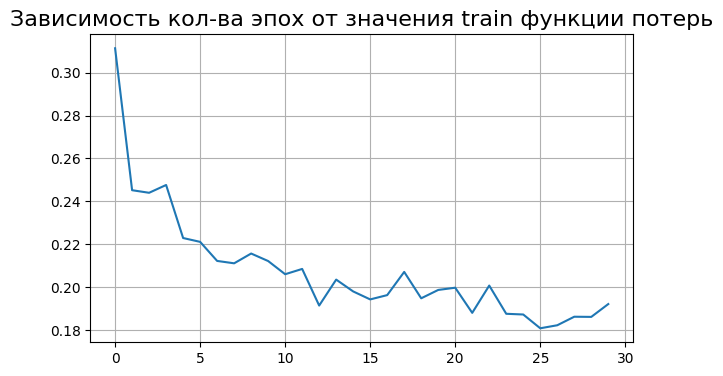

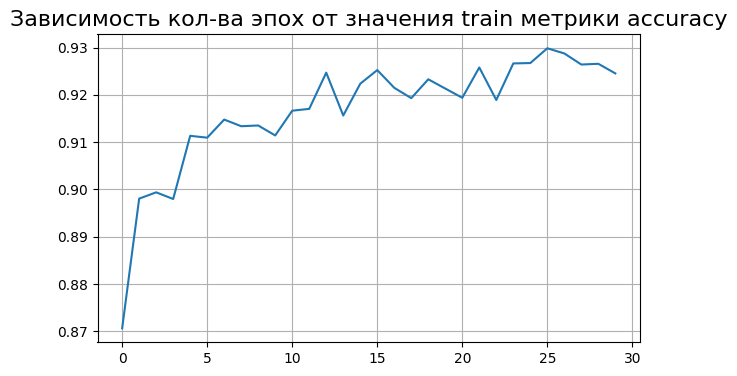

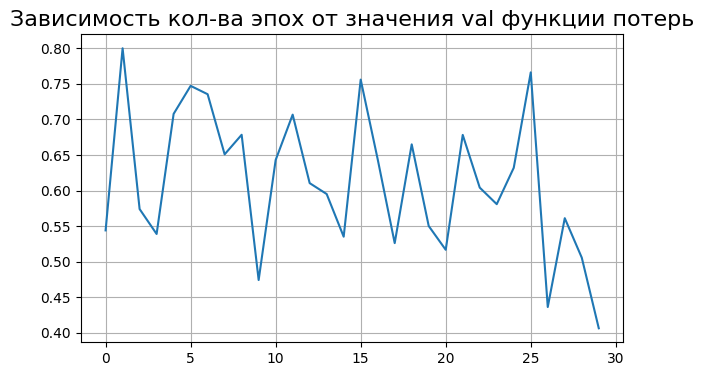

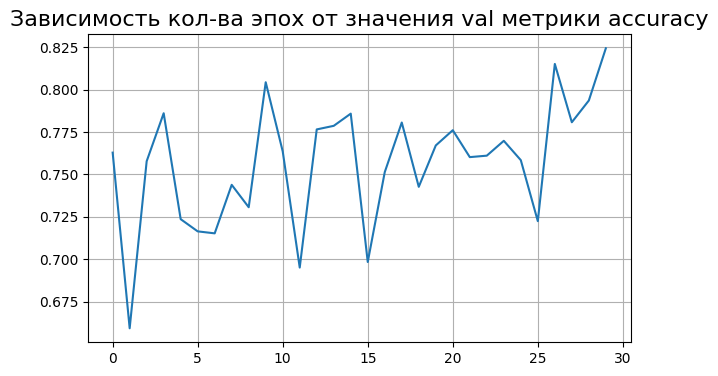

In [85]:
def plot_metrics(metric, caption):
    plt.figure(figsize=(7,4))
    plt.plot(list(range(0, len(metric))), metric)
    plt.title(f'Зависимость кол-ва эпох от значения {caption}', fontsize=16)
    plt.grid()


plot_metrics(losses['train'], 'train функции потерь')
plot_metrics(accs['train'], 'train метрики accuracy')
plot_metrics(losses['val'], 'val функции потерь')
plot_metrics(accs['val'], 'val метрики accuracy')

100%|██████████| 2921/2921 [22:27<00:00,  2.17it/s]


F1 = 0.14444407004301874,Acc = 0.5924723128778556,ROC-AUC = 0.5768991600751969


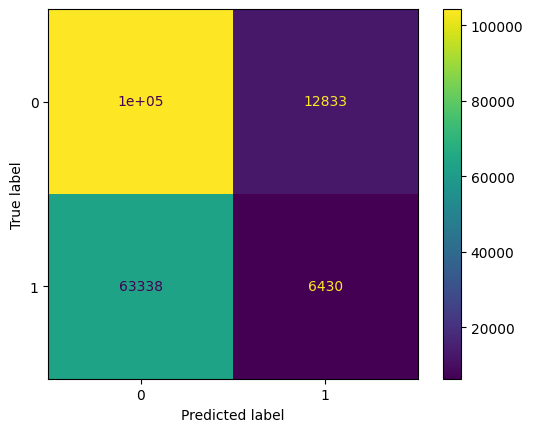

In [86]:
evaluate(test_loader, model)

Низкое качество на тесте (не сравнимое с валидацией) объясняется тем, что я не шафлил валидацию, и по сути валидация была только на классе 1.